In [1]:
import emd
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from scipy.signal import hilbert

In [2]:
lfp_hpc = io.loadmat(r'C:\Users\capta\Projects\Radbound University\OS Basic Dataset\HPC_100_CH38.continuous.mat')
lfp_pfc = io.loadmat(r'C:\Users\capta\Projects\Radbound University\OS Basic Dataset\PFC_100_CH34.continuous.mat')
states = io.loadmat(r'C:\Users\capta\Projects\Radbound University\OS Basic Dataset\post_trial5_2017-12-14_13-44-46-states.mat')


In [3]:
states

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Jul 13 15:21:59 2020',
 '__version__': '1.0',
 '__globals__': [],
 'states': array([[0, 0, 0, ..., 3, 3, 3]], dtype=uint8),
 'events': array([], shape=(0, 0), dtype=uint8),
 'transitions': array([[1.00000000e+00, 5.27587891e+01, 1.63552246e+02],
        [1.00000000e+00, 2.63793945e+01, 1.05517578e+02],
        [1.00000000e+00, 1.58276367e+01, 3.16552734e+01],
        [1.00000000e+00, 5.27587891e+00, 1.58276367e+01],
        [3.00000000e+00, 1.53000488e+02, 7.06967773e+02],
        [5.00000000e+00, 7.75554199e+02, 8.65244141e+02],
        [5.00000000e+00, 6.85864258e+02, 8.23037109e+02],
        [3.00000000e+00, 8.86347656e+02, 1.60914307e+03],
        [5.00000000e+00, 1.59859131e+03, 1.89404053e+03],
        [3.00000000e+00, 1.93097168e+03, 2.33721436e+03],
        [5.00000000e+00, 2.33721436e+03, 2.60628418e+03],
        [3.00000000e+00, 2.60628418e+03, 3.70366699e+03],
        [5.00000000e+00, 3.73532227e+03, 3.

In [4]:
hpc = lfp_hpc['HPC']
pfc = lfp_pfc['PFC']
states = states['states']

In [5]:
s_rate = 2500
seconds = 10
time = np.linspace(0,seconds,s_rate*seconds)

In [6]:
def get_rem_states(states, sample_rate):
    """
    Extract consecutive REM (Rapid Eye Movement) sleep states from a binary sleep state vector.

    Parameters:
    states (numpy.ndarray): A sleep state vector where 5 represents REM sleep and other values indicate non-REM.
    sample_rate (int or float): The sampling rate of the data.

    Returns:
    numpy.ndarray: An array of consecutive REM sleep state intervals in seconds, represented as (start, end) pairs.

    Notes:
    - This function processes a binary sleep state vector and identifies consecutive REM sleep intervals.
    - It calculates the start and end times of each REM state interval based on the provided sample rate.
    - The resulting intervals are returned as a numpy array of (start, end) pairs in seconds.
    """
    states = np.squeeze(states)
    rem_state_indices = np.where(states == 5)[0]
    rem_state_changes = np.diff(rem_state_indices)
    split_indices = np.where(rem_state_changes != 1)[0] + 1
    split_indices = np.concatenate(([0], split_indices, [len(rem_state_indices)]))
    consecutive_rem_states = np.empty((len(split_indices) - 1, 2))
    for i, (start, end) in enumerate(zip(split_indices, split_indices[1:])):
        start = rem_state_indices[start] * int(sample_rate)
        end = rem_state_indices[end - 1] * int(sample_rate)
        consecutive_rem_states[i] = np.array([start, end])
    consecutive_rem_states = np.array(consecutive_rem_states)
    null_states_mask = np.squeeze(np.diff(consecutive_rem_states) > 0)
    consecutive_rem_states = consecutive_rem_states[null_states_mask]
    return consecutive_rem_states

In [7]:
rem_states=get_rem_states(states, s_rate).astype(int)

for i,rem in enumerate(rem_states,start=1):
  print(f'REM {i} is from {rem[0]/s_rate} seconds (@ index {rem[0]}) to {rem[1]/s_rate} seconds (@ index {rem[1]})')
  

REM 1 is from 560.0 seconds (@ index 1400000) to 582.0 seconds (@ index 1455000)
REM 2 is from 716.0 seconds (@ index 1790000) to 865.0 seconds (@ index 2162500)
REM 3 is from 887.0 seconds (@ index 2217500) to 910.0 seconds (@ index 2275000)
REM 4 is from 1594.0 seconds (@ index 3985000) to 1786.0 seconds (@ index 4465000)
REM 5 is from 1823.0 seconds (@ index 4557500) to 1861.0 seconds (@ index 4652500)
REM 6 is from 2346.0 seconds (@ index 5865000) to 2412.0 seconds (@ index 6030000)
REM 7 is from 2505.0 seconds (@ index 6262500) to 2618.0 seconds (@ index 6545000)
REM 8 is from 3184.0 seconds (@ index 7960000) to 3214.0 seconds (@ index 8035000)
REM 9 is from 3475.0 seconds (@ index 8687500) to 3494.0 seconds (@ index 8735000)
REM 10 is from 3656.0 seconds (@ index 9140000) to 3663.0 seconds (@ index 9157500)
REM 11 is from 3718.0 seconds (@ index 9295000) to 3867.0 seconds (@ index 9667500)
REM 12 is from 4143.0 seconds (@ index 10357500) to 4151.0 seconds (@ index 10377500)
REM 1

In [8]:
first_rem_hpc=hpc[rem_states[0,0]:rem_states[0,1]]
first_rem_pfc=pfc[rem_states[0,0]:rem_states[0,1]]

first_rem_hpc = first_rem_hpc.squeeze()
first_rem_pfc = first_rem_pfc.squeeze()
print(first_rem_hpc.shape, first_rem_pfc.shape)

(55000,) (55000,)


In [9]:
imfs_hpc=emd.sift.sift(first_rem_hpc)
imfs_pfc = emd.sift.sift(first_rem_pfc)

In [10]:
def mean_imf_freq(imf,sample_rate,mode='nht'):
  IP,IF,IA=emd.spectra.frequency_transform(imf,s_rate,'nht')
  freq_vec=np.mean(IF,axis=0)
  print(f'The shape of freq Vectors {freq_vec.shape} and phase vector {IP.shape}')
  return freq_vec

In [11]:
theta_band = (4, 8)
imf_freqs = mean_imf_freq(imfs_hpc, s_rate)
theta_imf_indices = np.where((imf_freqs >= theta_band[0]) & (imf_freqs <= theta_band[1]))[0]

print(f"IMF frequencies: {imf_freqs}")
print(f"Theta band: {theta_band}")
print(f"IMF indices in theta band: {theta_imf_indices}")
print(f"Corresponding theta frequencies: {imf_freqs[theta_imf_indices]}")

# Get the actual IMF components that fall in theta range
theta_imfs = imfs_hpc[:, theta_imf_indices]  # Extract only theta IMFs
print(f"Shape of theta IMFs: {theta_imfs.shape}")

# Show details for each theta IMF
for i, idx in enumerate(theta_imf_indices):
    print(f"IMF {idx}: frequency = {imf_freqs[idx]:.2f} Hz")

The shape of freq Vectors (11,) and phase vector (55000, 11)
IMF frequencies: [5.82231760e+02 2.48165182e+02 8.45750109e+01 3.00825837e+01
 1.08138115e+01 4.54374205e+00 2.17528905e+00 8.62284969e-01
 3.60286594e-01 1.32632423e-01 8.83553326e-02]
Theta band: (4, 8)
IMF indices in theta band: [5]
Corresponding theta frequencies: [4.54374205]
Shape of theta IMFs: (55000, 1)
IMF 5: frequency = 4.54 Hz


In [12]:
gamma_band = (30,120)
imf_freqs = mean_imf_freq(imfs_pfc, s_rate)
gamma_imf_indices = np.where((imf_freqs >= gamma_band[0]) & (imf_freqs <= gamma_band[1]))[0]

print(f"IMF frequencies: {imf_freqs}")
print(f"Theta band: {gamma_band}")
print(f"IMF indices in theta band: {gamma_imf_indices}")
print(f"Corresponding theta frequencies: {imf_freqs[theta_imf_indices]}")

# Get the actual IMF components that fall in theta range
gamma_imfs = imfs_pfc[:, gamma_imf_indices]  # Extract only theta IMFs
print(f"Shape of theta IMFs: {gamma_imf_indices}")

# Show details for each theta IMF
for i, idx in enumerate(gamma_imf_indices):
    print(f"IMF {idx}: frequency = {imf_freqs[idx]:.2f} Hz")

The shape of freq Vectors (11,) and phase vector (55000, 11)
IMF frequencies: [5.71856214e+02 2.52327310e+02 8.46885696e+01 3.58219223e+01
 1.37643530e+01 5.81320365e+00 2.40628928e+00 1.04254595e+00
 4.49243996e-01 1.78457591e-01 4.54577127e-02]
Theta band: (30, 120)
IMF indices in theta band: [2 3]
Corresponding theta frequencies: [5.81320365]
Shape of theta IMFs: [2 3]
IMF 2: frequency = 84.69 Hz
IMF 3: frequency = 35.82 Hz


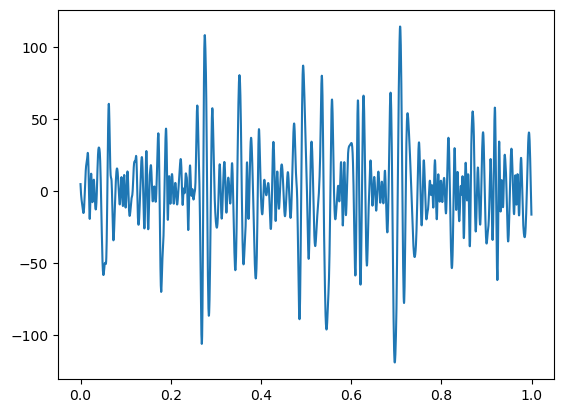

In [13]:

plt.plot(time[:s_rate], gamma_imfs[:s_rate,0], label='HPC LFP')

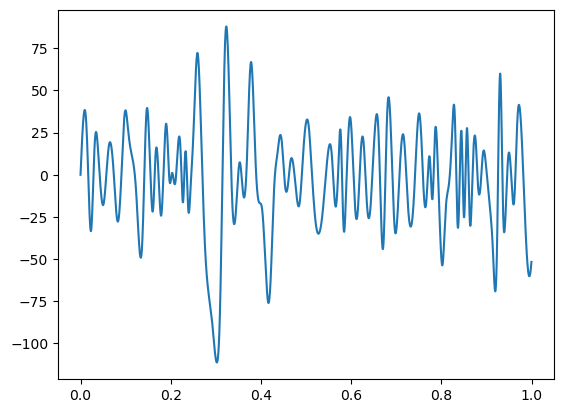

In [14]:

plt.plot(time[:s_rate], gamma_imfs[:s_rate,1], label='HPC LFP')

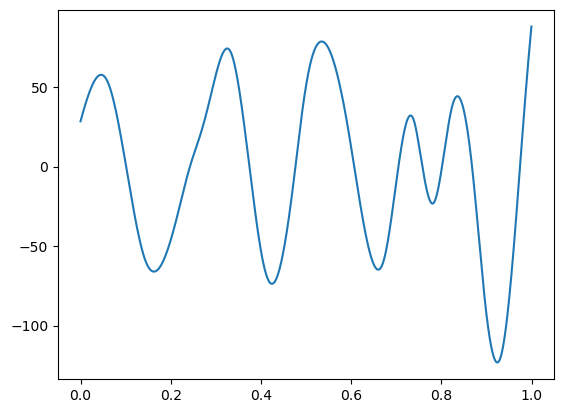

In [15]:
plt.plot(time[:s_rate], theta_imfs[:s_rate,0], label='HPC LFP')

In [16]:
def z_score_normalize(data):
    """Z-score normalize along the time axis (axis=0)"""
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Apply z-score normalization to your IMFs
theta_imfs_normalized = z_score_normalize(theta_imfs)
gamma_imfs_normalized = z_score_normalize(gamma_imfs)

# Extract instantaneous phases from normalized data
theta_phase = np.angle(hilbert(theta_imfs_normalized[:, 0]))
gamma_phase = np.angle(hilbert(gamma_imfs_normalized[:, 0]))

print(f"Normalized theta phase range: {np.min(theta_phase):.2f} to {np.max(theta_phase):.2f}")
print(f"Normalized gamma phase range: {np.min(gamma_phase):.2f} to {np.max(gamma_phase):.2f}")

good_theta_cycles = emd.cycles.get_cycle_vector(theta_phase)
good_gamma_cycles = emd.cycles.get_cycle_vector(gamma_phase)

print(f'Total theta cycles detected are {good_theta_cycles.max()}')
print(f'Total gamma cycles detected are {good_gamma_cycles.max()}')

Normalized theta phase range: -3.14 to 3.14
Normalized gamma phase range: -3.14 to 3.14
Total theta cycles detected are -1
Total gamma cycles detected are -1


In [17]:
theta_cycles = emd.cycles.Cycles(theta_phase)
gamma_cycles = emd.cycles.Cycles(gamma_phase)

print(f"Theta cycles detected: {theta_cycles.ncycles}")
print(f"Gamma cycles detected: {gamma_cycles.ncycles}")

Theta cycles detected: 97
Gamma cycles detected: 1743


In [19]:
def compute_cycle_ppc(theta_phase_cycle, gamma_phase_cycle):
    """
    Compute PPC for a single cycle using the formula from Vinck et al. 2010[3]
    """
    # Ensure we have enough data points
    if len(theta_phase_cycle) < 3 or len(gamma_phase_cycle) < 3:
        return np.nan
    
    # Interpolate gamma phases to match theta cycle length
    if len(theta_phase_cycle) != len(gamma_phase_cycle):
        gamma_interp = np.interp(
            np.linspace(0, 1, len(theta_phase_cycle)),
            np.linspace(0, 1, len(gamma_phase_cycle)),
            gamma_phase_cycle
        )
    else:
        gamma_interp = gamma_phase_cycle
    
    # Compute phase difference
    phase_diff = theta_phase_cycle - gamma_interp
    
    # PPC calculation using the dot product formula[3]
    n = len(phase_diff)
    if n < 2:
        return np.nan
    
    ppc_sum = 0
    count = 0
    
    for j in range(n-1):
        for k in range(j+1, n):
            # f(φj, φk) = cos(φj)cos(φk) + sin(φj)sin(φk)
            dot_product = (np.cos(phase_diff[j]) * np.cos(phase_diff[k]) + 
                          np.sin(phase_diff[j]) * np.sin(phase_diff[k]))
            ppc_sum += dot_product
            count += 1
    
    return (2 / (n * (n - 1))) * ppc_sum if count > 0 else np.nan

# Perform cycle-by-cycle analysis
cycle_ppc_values = []
cycle_info = []

# Iterate through theta cycles
for theta_cycle_idx in range(theta_cycles.ncycles):
    # Get indices for this theta cycle
    theta_cycle_inds = theta_cycles.get_inds_of_cycle(theta_cycle_idx)
    
    if len(theta_cycle_inds) == 0:
        continue
    
    # Extract theta phase for this cycle
    theta_phase_cycle = theta_phase[theta_cycle_inds]
    
    # Find overlapping gamma cycles during this theta cycle
    theta_start, theta_end = theta_cycle_inds[0], theta_cycle_inds[-1]
    
    # Get gamma phases during theta cycle period
    gamma_phase_cycle = gamma_phase[theta_start:theta_end+1]
    
    # Compute PPC for this cycle
    cycle_ppc = compute_cycle_ppc(theta_phase_cycle, gamma_phase_cycle)
    
    if not np.isnan(cycle_ppc):
        cycle_ppc_values.append(cycle_ppc)
        cycle_info.append({
            'theta_cycle': theta_cycle_idx,
            'start_time': theta_start,
            'end_time': theta_end,
            'duration': len(theta_cycle_inds),
            'ppc': cycle_ppc
        })

print(f"Analyzed {len(cycle_ppc_values)} valid theta cycles")
print(f"Mean cycle PPC: {np.mean(cycle_ppc_values):.4f} ± {np.std(cycle_ppc_values):.4f}")

Analyzed 97 valid theta cycles
Mean cycle PPC: 0.0069 ± 0.0111


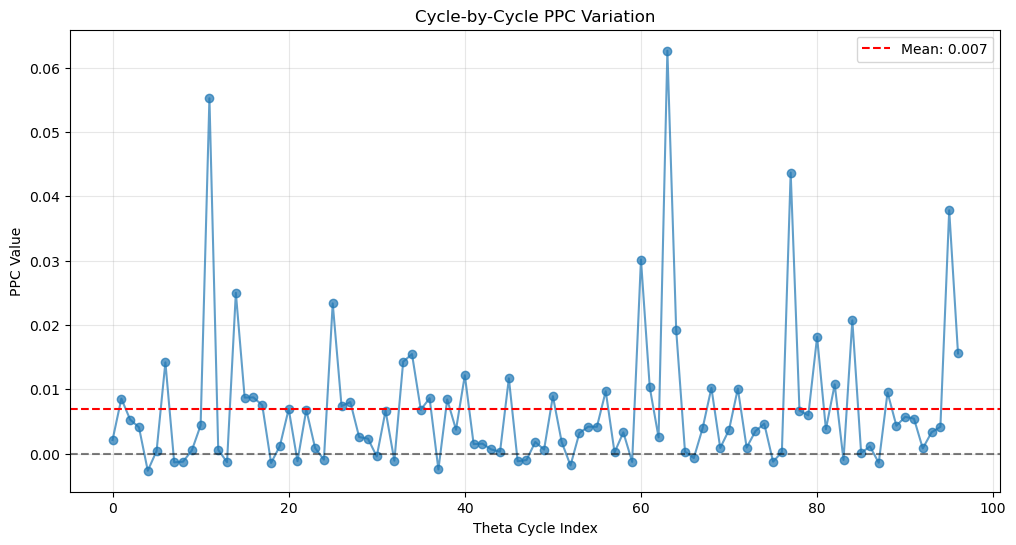

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(cycle_ppc_values)), cycle_ppc_values, 'o-', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axhline(y=np.mean(cycle_ppc_values), color='r', linestyle='--', 
                  label=f'Mean: {np.mean(cycle_ppc_values):.3f}')
plt.xlabel('Theta Cycle Index')
plt.ylabel('PPC Value')
plt.title('Cycle-by-Cycle PPC Variation')
plt.legend()
plt.grid(True, alpha=0.3)